<h1> Engineer Holidayness Feature </h1>

In this notebook, we aim to develop a single **holidayness feature** from the holiday and school-free flags in the DataFrame`DE_hol_df` with a high predictivity for the grid load. For this we apply two paramter-dependend mathematical operations:

- A convex combination of the holiday and school-free flags.
- A "smoothing" of the resulting combined values.  

The second operation reflects observations from OPSD_EDA.ipynb that weekends tend to reduce grid load on adjacent workdays. We assume at this point, that holidayness also accumulates during long holiday or school-free perdiods, like Easter, Christmas, or the summer holidays.  
Since holidays and school periods are subject to state law in Germany, we will work with the **TransnetBW** grid load data and the holiday data for the state of **Baden-Württemberg** to optimize our holidayness feature. This is for the simple reason that this is the only matching pair of load and holiday data available to us.  

In [1]:
from pathlib import Path
import sys
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import config as cfg
from src import eda_utils
from src import plotting_utils as plu
from src import config as cfg
from src import filter_group_aggr_utils as fga
from src import feature_anal_eng as fae 

from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
import math


<h2> Build the Baden-Württemberg DataFrame </h2>

We load the DataFrames from the `../data/processed` Folder 

In [2]:
DATA_PROCESSED = Path("../data/processed")

# --- Load Parquet files ---
OPSD_60min_DE_LU_df = pd.read_parquet(DATA_PROCESSED / "OPSD_60min_de_lu_df.parquet")
DE_hol_df  = pd.read_parquet(DATA_PROCESSED / "DE_hol_df.parquet")

# --- Quick check ---
print("Loaded DataFrames:")
print(f"OPSD_60min_DE_LU_df.shape: {OPSD_60min_DE_LU_df.shape}")
print(f"DE_hol_df.shape: {DE_hol_df.shape}")


Loaded DataFrames:
OPSD_60min_DE_LU_df.shape: (50401, 45)
DE_hol_df.shape: (7670, 37)


We make copies of the DataFrames, with features relevant to **Baden-Württemberg**  only. 

In [3]:
DE_BW_hol_df = DE_hol_df[[ "local_date", "local_start", "local_end",	"utc_start",	"utc_end",	"DE_BW_school_free",	"DE_BW_hol"]].copy()
DE_BW_hol_df.head(5)

,local_date,local_start,local_end,utc_start,utc_end,DE_BW_school_free,DE_BW_hol
0,2015-01-01,2015-01-01 00:00:00+01:00,2015-01-02 00:00:00+01:00,2014-12-31 23:00:00+00:00,2015-01-01 23:00:00+00:00,1,1
1,2015-01-02,2015-01-02 00:00:00+01:00,2015-01-03 00:00:00+01:00,2015-01-01 23:00:00+00:00,2015-01-02 23:00:00+00:00,1,0
2,2015-01-03,2015-01-03 00:00:00+01:00,2015-01-04 00:00:00+01:00,2015-01-02 23:00:00+00:00,2015-01-03 23:00:00+00:00,1,0
3,2015-01-04,2015-01-04 00:00:00+01:00,2015-01-05 00:00:00+01:00,2015-01-03 23:00:00+00:00,2015-01-04 23:00:00+00:00,1,0
4,2015-01-05,2015-01-05 00:00:00+01:00,2015-01-06 00:00:00+01:00,2015-01-04 23:00:00+00:00,2015-01-05 23:00:00+00:00,1,0


In [4]:
BW_cols = [col for col in OPSD_60min_DE_LU_df.columns if ("transnetbw" in col) or  ("timestamp" in col)]
print(BW_cols)

['utc_timestamp', 'cet_cest_timestamp', 'DE_transnetbw_load_actual_entsoe_transparency', 'DE_transnetbw_load_forecast_entsoe_transparency', 'DE_transnetbw_solar_generation_actual', 'DE_transnetbw_wind_onshore_generation_actual']


In [5]:
OPSD_60min_BW_df =  OPSD_60min_DE_LU_df[BW_cols].copy()
print(OPSD_60min_BW_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 6 columns):
 #   Column                                           Non-Null Count  Dtype                        
---  ------                                           --------------  -----                        
 0   utc_timestamp                                    50401 non-null  datetime64[ns, UTC]          
 1   cet_cest_timestamp                               50401 non-null  datetime64[ns, Europe/Berlin]
 2   DE_transnetbw_load_actual_entsoe_transparency    50400 non-null  float64                      
 3   DE_transnetbw_load_forecast_entsoe_transparency  50376 non-null  float64                      
 4   DE_transnetbw_solar_generation_actual            50386 non-null  float64                      
 5   DE_transnetbw_wind_onshore_generation_actual     50400 non-null  float64                      
dtypes: datetime64[ns, Europe/Berlin](1), datetime64[ns, UTC](1), float64(4)
memory usage: 2

We initialize the holiday and school-free columns of `OPSD_60min_BW_df`.

In [6]:
OPSD_60min_BW_df["DE_BW_hol"] = np.uint8(0)
OPSD_60min_BW_df["DE_BW_school_free"] = np.uint8(0)

We iterate over each `utc_timestamp` in `OPSD_60min_BW_df` and, for each hour, look up the corresponding holiday and school-free flags in `DE_BW_hol_df`, then assign these values to the matching row in `OPSD_60min_BW_df`.
 

In [7]:
for idx, utc_ts in OPSD_60min_BW_df["utc_timestamp"].items():  
    row = DE_BW_hol_df.loc[
        (DE_BW_hol_df["utc_start"] < utc_ts) &
        (utc_ts <= DE_BW_hol_df["utc_end"]),
        ["DE_BW_hol", "DE_BW_school_free"]
    ]
    if not row.empty:
        OPSD_60min_BW_df.at[idx, "DE_BW_hol"] = np.uint8(row["DE_BW_hol"].iloc[0])
        OPSD_60min_BW_df.at[idx, "DE_BW_school_free"] = np.uint8(row["DE_BW_school_free"].iloc[0])


print("Flags assigned by timestamp iteration.")
print(OPSD_60min_BW_df[["utc_timestamp", "DE_BW_hol", "DE_BW_school_free"]].head())


Flags assigned by timestamp iteration.
              utc_timestamp  DE_BW_hol  DE_BW_school_free
0 2014-12-31 23:00:00+00:00          0                  0
1 2015-01-01 00:00:00+00:00          1                  1
2 2015-01-01 01:00:00+00:00          1                  1
3 2015-01-01 02:00:00+00:00          1                  1
4 2015-01-01 03:00:00+00:00          1                  1


In [8]:
BW_load_hol_df = OPSD_60min_BW_df[["utc_timestamp","cet_cest_timestamp","DE_transnetbw_load_actual_entsoe_transparency", "DE_BW_hol",	"DE_BW_school_free"]]
BW_load_hol_df.head(5)

,utc_timestamp,cet_cest_timestamp,DE_transnetbw_load_actual_entsoe_transparency,DE_BW_hol,DE_BW_school_free
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,0,0
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,5307.0,1,1
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,5087.0,1,1
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,4906.0,1,1
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,4865.0,1,1


<h2> Hourly Profile depending on Holiday Status</h2>

OPSD follows end of the hour convention, the timestamps represent the hours ending at the timestamp's time. Therefore, we must make sure, that 00:00 timestamps are grouped to the day ending at that time. For this, we subtract a nanosecond. 

In [9]:
mon_mask = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(0,))  # Mon
tue_mask = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(1,))  # Tue
wed_mask = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(2,))  # Wed
thu_mask = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(3,))  # Thu
fri_mask   = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(4,))    # Fri
sat_mask   = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(5,))    # Sat
sun_mask   = fga.make_weekday_mask(BW_load_hol_df, "cet_cest_timestamp", weekdays=(6,))    # Sun

In [10]:
BW_hol_mask = BW_load_hol_df["DE_BW_hol"]==1
BW_school_free_mask = BW_load_hol_df["DE_BW_school_free"]==1
BW_school_day_mask = BW_load_hol_df["DE_BW_school_free"]==0

In [11]:
BW_load_hol_df[fri_mask ].head(5)

,utc_timestamp,cet_cest_timestamp,DE_transnetbw_load_actual_entsoe_transparency,DE_BW_hol,DE_BW_school_free
25,2015-01-02 00:00:00+00:00,2015-01-02 01:00:00+01:00,4990.0,0,1
26,2015-01-02 01:00:00+00:00,2015-01-02 02:00:00+01:00,4860.0,0,1
27,2015-01-02 02:00:00+00:00,2015-01-02 03:00:00+01:00,4761.0,0,1
28,2015-01-02 03:00:00+00:00,2015-01-02 04:00:00+01:00,4913.0,0,1
29,2015-01-02 04:00:00+00:00,2015-01-02 05:00:00+01:00,5055.0,0,1


First, we build profiles for all weekdays **without restrictions** to any holiday type.

In [12]:
BW_mon_prof, BW_mon_meta = fga.aggregate_hourly_profile(BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", 
                                                                "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=mon_mask, drop_dst_switch_dates=True, return_counts=True
)
BW_tue_prof, BW_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=tue_mask, drop_dst_switch_dates=True, return_counts=True
)
BW_wed_prof, BW_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask= wed_mask, drop_dst_switch_dates=True, return_counts=True
)
BW_thu_prof, BW_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask= thu_mask, drop_dst_switch_dates=True, return_counts=True
)
BW_fri_prof, BW_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask= fri_mask , drop_dst_switch_dates=True, return_counts=True
)
BW_sat_prof, BW_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask= sat_mask , drop_dst_switch_dates=True, return_counts=True
)
BW_sun_prof, BW_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask= sun_mask , drop_dst_switch_dates=True, return_counts=True
)


We build the **holiday profiles**.

In [13]:
BW_hol_mon_prof, BW_hol_mon_meta = fga.aggregate_hourly_profile(BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", 
                                                                "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_tue_prof, BW_hol_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_wed_prof, BW_hol_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_thu_prof, BW_hol_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_fri_prof, BW_hol_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_sat_prof, BW_hol_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(sat_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_hol_sun_prof, BW_hol_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask=(sun_mask)&(BW_hol_mask), drop_dst_switch_dates=True, return_counts=True
)


Next, the school-free profiles. 

In [14]:
BW_school_free_mon_prof, BW_school_free_mon_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_tue_prof, BW_school_free_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_wed_prof, BW_school_free_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_thu_prof, BW_school_free_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_fri_prof, BW_school_free_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_sat_prof, BW_school_free_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(sat_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_free_sun_prof, BW_school_free_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask=(sun_mask)&(BW_school_free_mask), drop_dst_switch_dates=True, return_counts=True
)


We also restrict to non-school-free days. That is: School days.

In [15]:
BW_school_day_mon_prof, BW_school_day_mon_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_day_tue_prof, BW_school_day_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_day_wed_prof, BW_school_day_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_day_thu_prof, BW_school_day_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_day_fri_prof, BW_school_day_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_school_day_mask), drop_dst_switch_dates=True, return_counts=True
)



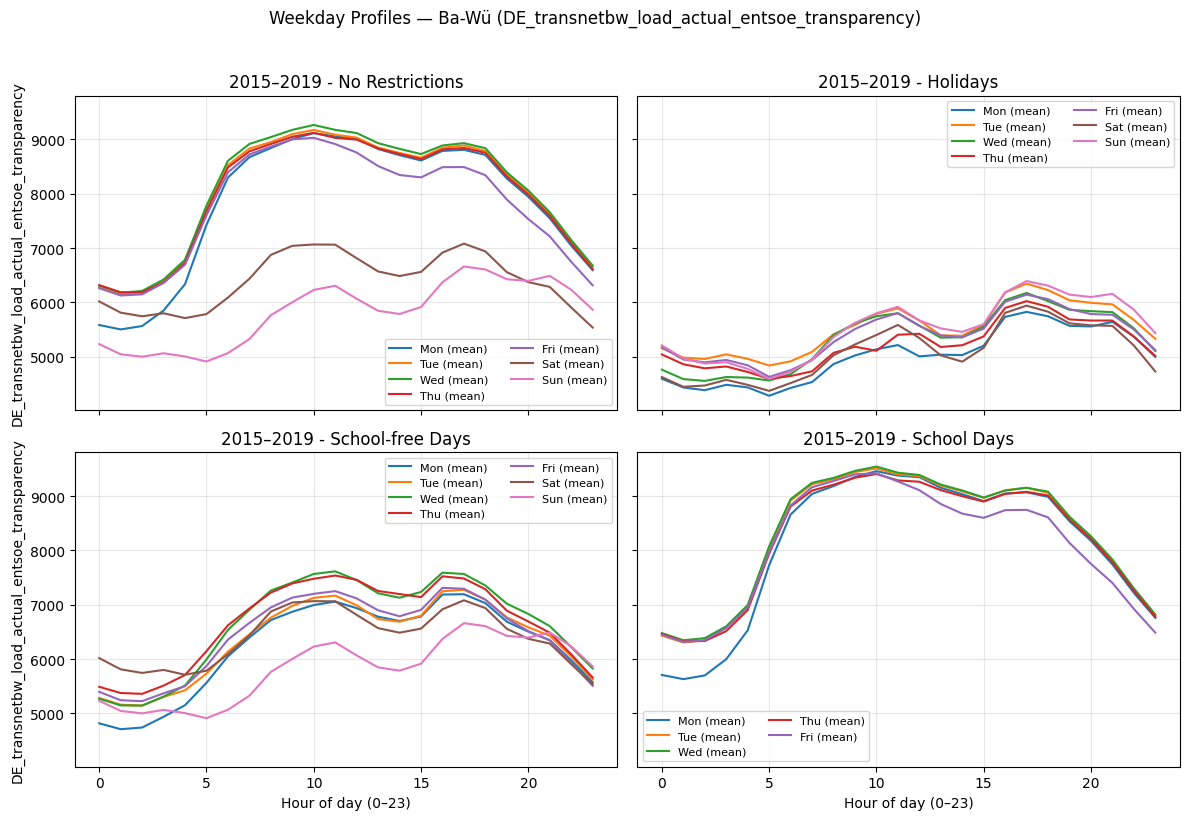

In [16]:
profiles_no_restr = [
    ("Mon (mean)", BW_mon_prof),
    ("Tue (mean)", BW_tue_prof),
    ("Wed (mean)", BW_wed_prof),
    ("Thu (mean)", BW_thu_prof),
    ("Fri (mean)", BW_fri_prof),
    ("Sat (mean)", BW_sat_prof),
    ("Sun (mean)", BW_sun_prof),
]
profiles_BW_hol = [
    ("Mon (mean)", BW_hol_mon_prof),
    ("Tue (mean)", BW_hol_tue_prof),
    ("Wed (mean)", BW_hol_wed_prof),
    ("Thu (mean)", BW_hol_thu_prof),
    ("Fri (mean)", BW_hol_fri_prof),
    ("Sat (mean)", BW_hol_sat_prof),
    ("Sun (mean)", BW_hol_sun_prof),
]
profiles_BW_school_free = [
    ("Mon (mean)", BW_school_free_mon_prof),
    ("Tue (mean)", BW_school_free_tue_prof),
    ("Wed (mean)", BW_school_free_wed_prof),
    ("Thu (mean)", BW_school_free_thu_prof),
    ("Fri (mean)", BW_school_free_fri_prof),
    ("Sat (mean)", BW_school_free_sat_prof),
    ("Sun (mean)", BW_school_free_sun_prof),
]
profiles_BW_school_day = [
    ("Mon (mean)", BW_school_day_mon_prof),
    ("Tue (mean)", BW_school_day_tue_prof),
    ("Wed (mean)", BW_school_day_wed_prof),
    ("Thu (mean)", BW_school_day_thu_prof),
    ("Fri (mean)", BW_school_day_fri_prof),  
]
# --- Create 2×2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
(ax11, ax12), (ax21, ax22) = axes
# Top row
(plu.plot_weekday_set(ax11, profiles_no_restr , "2015–2019 - No Restrictions", 
                   ylabel="DE_transnetbw_load_actual_entsoe_transparency", xlabel=False))
(plu.plot_weekday_set(ax12, profiles_BW_hol, "2015–2019 - Holidays", ylabel=None, xlabel=False))
# Bottom row
(plu.plot_weekday_set(ax21, profiles_BW_school_free, "2015–2019 - School-free Days", 
                   ylabel="DE_transnetbw_load_actual_entsoe_transparency", xlabel=True))
(plu.plot_weekday_set(ax22, profiles_BW_school_day, "2015–2019 - School Days", ylabel=None, xlabel=True))

fig.suptitle(
    "Weekday Profiles — Ba-Wü (DE_transnetbw_load_actual_entsoe_transparency)",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()


<h2> Innerness and Outerness of School-Holidays  </h2>

In this section, we test our assumption, that the depth of school-free periods influences electricity demand.  Do days that are part of a longer school break show lower hourly loads than single or edge school-free days?  

<h3> Adding Innerness Feature </h3>

For this, we first extend the DataFrame `BW_load_hol_df` adding four new numeric columns that describe, for each hour,  how deeply it lies **inside** a streak of school-free (1) or non-school-free (0) periods.  The columns are computed using the helper function  
`add_innerness_and_outerness(df, flag_col)`, it follows a **distance-based logic**:

| Column name | Meaning | Applied to  `BW_load_hol_df` |
|--------------|----------|----------------|
| `<flag_col>_backw_innerness` | Rows **since** the last `0` flag | school-free hours before |
| `<flag_col>_forw_innerness`  | Rows **until** the next `0` flag | school-free hours to come |
| `<flag_col>_backw_outerness` | Rows **since** the last `1` flag | school-day hours before |
| `<flag_col>_forw_outerness`  | Rows **until** the  next`1` flag | school-day hours to come |


The function assumes **virtual opposite flags** at both ends of the series:   Outside values are treated as the opposite flag.

In [17]:
BW_load_hol_df_hol_inout =fae.add_innerness_and_outerness(BW_load_hol_df , "DE_BW_school_free")

In [27]:
BW_load_hol_df_hol_inout

,utc_timestamp,cet_cest_timestamp,DE_transnetbw_load_actual_entsoe_transparency,DE_BW_hol,DE_BW_school_free,DE_BW_school_free_backw_innerness,DE_BW_school_free_forw_innerness,DE_BW_school_free_backw_outerness,DE_BW_school_free_forw_outerness
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,0,0,0,0,1,1
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,5307.0,1,1,1,144,0,0
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,5087.0,1,1,2,143,0,0
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,4906.0,1,1,3,142,0,0
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,4865.0,1,1,4,141,0,0
...,...,...,...,...,...,...,...,...,...
50396,2020-09-30 19:00:00+00:00,2020-09-30 21:00:00+02:00,7657.0,0,0,0,0,69,5
50397,2020-09-30 20:00:00+00:00,2020-09-30 22:00:00+02:00,7072.0,0,0,0,0,70,4
50398,2020-09-30 21:00:00+00:00,2020-09-30 23:00:00+02:00,6465.0,0,0,0,0,71,3
50399,2020-09-30 22:00:00+00:00,2020-10-01 00:00:00+02:00,5963.0,0,0,0,0,72,2


In [ ]:
BW_school_freeness_1_2_mask = (BW_load_hol_df_hol_inout["DE_BW_school_free_backw_innerness"] >= 1 * 24) & (BW_load_hol_df_hol_inout["DE_BW_school_free_forw_innerness"] >= 2 * 24)
BW_school_freeness_2_2_mask = (BW_load_hol_df_hol_inout["DE_BW_school_free_backw_innerness"] >= 2 * 24) & (BW_load_hol_df_hol_inout["DE_BW_school_free_forw_innerness"] >= 2 * 24)
BW_school_freeness_2_3_mask = (BW_load_hol_df_hol_inout["DE_BW_school_free_backw_innerness"] >= 2 * 24) & (BW_load_hol_df_hol_inout["DE_BW_school_free_forw_innerness"] >= 3 * 24)

In [20]:
BW_school_freeness_1_2_mon_prof, BW_school_freeness_1_2_mon_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_school_freeness_1_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_1_2_tue_prof, BW_school_freeness_1_2_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_school_freeness_1_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_1_2_wed_prof, BW_school_freeness_1_2_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_school_freeness_1_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_1_2_thu_prof, BW_school_freeness_1_2_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_school_freeness_1_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_1_2_fri_prof, BW_school_freeness_1_2_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_school_freeness_1_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_1_2_sat_prof, BW_school_freeness_1_2_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(sat_mask)&(BW_school_freeness_1_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_1_2_sun_prof, BW_school_freeness_1_2_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask=(sun_mask)&(BW_school_freeness_1_2_mask), drop_dst_switch_dates=True, return_counts=True
)


In [21]:
BW_school_freeness_2_2_mon_prof, BW_school_freeness_2_2_mon_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_school_freeness_2_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_2_tue_prof, BW_school_freeness_2_2_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_school_freeness_2_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_2_wed_prof, BW_school_freeness_2_2_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_school_freeness_2_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_2_thu_prof, BW_school_freeness_2_2_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_school_freeness_2_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_2_fri_prof, BW_school_freeness_2_2_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_school_freeness_2_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_2_sat_prof, BW_school_freeness_2_2_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(sat_mask)&(BW_school_freeness_2_2_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_2_sun_prof, BW_school_freeness_2_2_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask=(sun_mask)&(BW_school_freeness_2_2_mask), drop_dst_switch_dates=True, return_counts=True
)


In [22]:
BW_school_freeness_2_3_mon_prof, BW_school_freeness_2_3_mon_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(mon_mask) & (BW_school_freeness_2_3_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_3_tue_prof, BW_school_freeness_2_3_tue_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(tue_mask)&(BW_school_freeness_2_3_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_3_wed_prof, BW_school_freeness_2_3_wed_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(wed_mask)&(BW_school_freeness_2_3_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_3_thu_prof, BW_school_freeness_2_3_thu_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(thu_mask)&(BW_school_freeness_2_3_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_3_fri_prof, BW_school_freeness_2_3_fri_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(fri_mask)&(BW_school_freeness_2_3_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_3_sat_prof, BW_school_freeness_2_3_sat_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31", ts_col="utc_timestamp", agg="mean",
    mask=(sat_mask)&(BW_school_freeness_2_3_mask), drop_dst_switch_dates=True, return_counts=True
)
BW_school_freeness_2_3_sun_prof, BW_school_freeness_2_3_sun_meta = fga.aggregate_hourly_profile(
    BW_load_hol_df, "DE_transnetbw_load_actual_entsoe_transparency", "2015-01-01", "2019-12-31",ts_col="utc_timestamp", agg="mean",
    mask=(sun_mask)&(BW_school_freeness_2_3_mask), drop_dst_switch_dates=True, return_counts=True
)


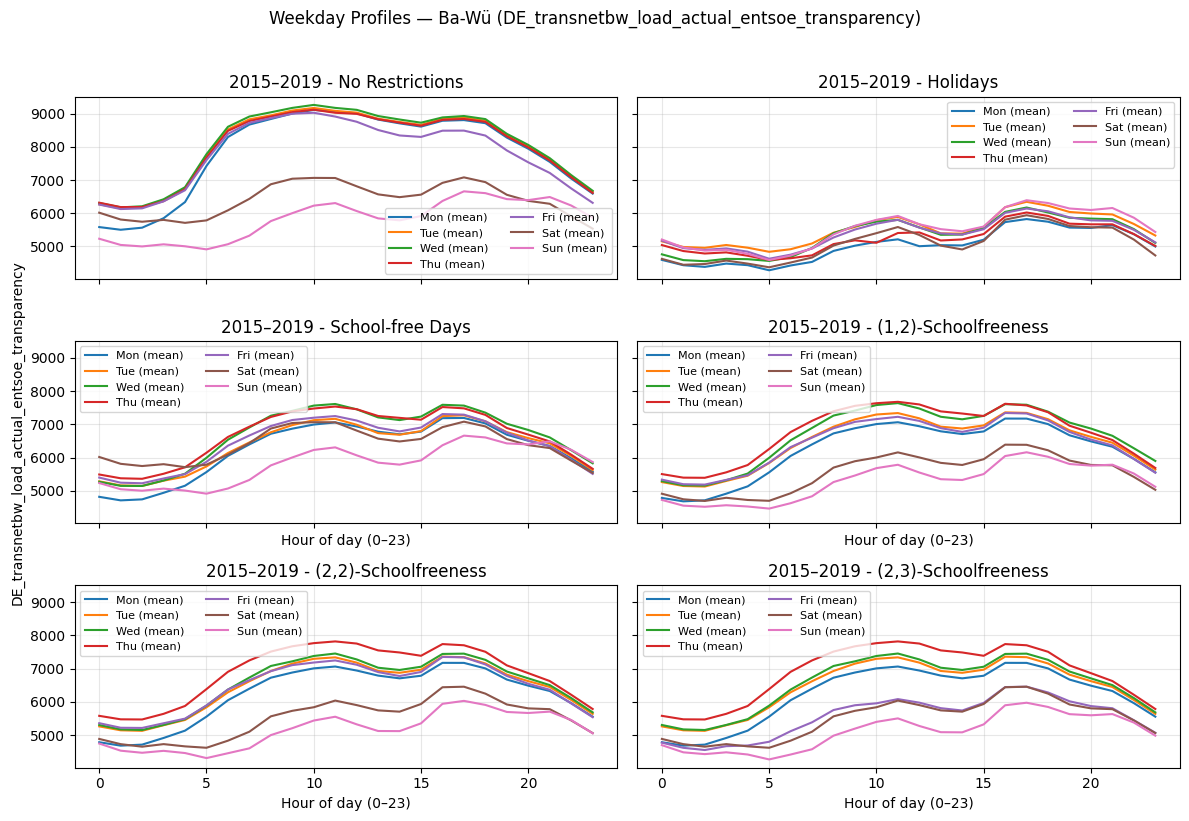

In [26]:
# --- Assemble profile lists ---
profiles_BW_school_freeness_1_2 = [
    ("Mon (mean)", BW_school_freeness_1_2_mon_prof),
    ("Tue (mean)", BW_school_freeness_1_2_tue_prof),
    ("Wed (mean)", BW_school_freeness_1_2_wed_prof),
    ("Thu (mean)", BW_school_freeness_1_2_thu_prof),
    ("Fri (mean)", BW_school_freeness_1_2_fri_prof),  
     ("Sat (mean)", BW_school_freeness_1_2_sat_prof),
    ("Sun (mean)", BW_school_freeness_1_2_sun_prof),
]
profiles_BW_school_freeness_2_2 = [
    ("Mon (mean)", BW_school_freeness_2_2_mon_prof),
    ("Tue (mean)", BW_school_freeness_2_2_tue_prof),
    ("Wed (mean)", BW_school_freeness_2_2_wed_prof),
    ("Thu (mean)", BW_school_freeness_2_2_thu_prof),
    ("Fri (mean)", BW_school_freeness_2_2_fri_prof),  
     ("Sat (mean)", BW_school_freeness_2_2_sat_prof),
    ("Sun (mean)", BW_school_freeness_2_2_sun_prof),
]
profiles_BW_school_freeness_2_3 = [
    ("Mon (mean)", BW_school_freeness_2_3_mon_prof),
    ("Tue (mean)", BW_school_freeness_2_3_tue_prof),
    ("Wed (mean)", BW_school_freeness_2_3_wed_prof),
    ("Thu (mean)", BW_school_freeness_2_3_thu_prof),
    ("Fri (mean)", BW_school_freeness_2_3_fri_prof),  
     ("Sat (mean)", BW_school_freeness_2_3_sat_prof),
    ("Sun (mean)", BW_school_freeness_2_3_sun_prof),
]

# --- Create 2×2 grid ---
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
(ax11, ax12), (ax21, ax22), (ax31, ax32) = axes
# Top row
(plu.plot_weekday_set(ax11, profiles_no_restr , "2015–2019 - No Restrictions", 
                   ylabel=None, xlabel=False))
(plu.plot_weekday_set(ax12, profiles_BW_hol, "2015–2019 - Holidays", ylabel=None, xlabel=False))
# Middle row
(plu.plot_weekday_set(ax21, profiles_BW_school_free, "2015–2019 - School-free Days", 
                   ylabel="DE_transnetbw_load_actual_entsoe_transparency", xlabel=True))
(plu.plot_weekday_set(ax22, profiles_BW_school_freeness_1_2, "2015–2019 - (1,2)-Schoolfreeness", ylabel=None, xlabel=True))
# Bottom row
(plu.plot_weekday_set(ax31, profiles_BW_school_freeness_2_2, "2015–2019 - (2,2)-Schoolfreeness", 
                   ylabel=None, xlabel=True))
(plu.plot_weekday_set(ax32, profiles_BW_school_freeness_2_3, "2015–2019 - (2,3)-Schoolfreeness", ylabel=None, xlabel=True))

fig.suptitle(
    "Weekday Profiles — Ba-Wü (DE_transnetbw_load_actual_entsoe_transparency)",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()


<h3> Observation </h3>

The impact of school-holiday innerness differs by weekday.  In general, the deeper inside a school-free period, the lower the grid load. For some weekdays however, especially **Thursdays**, the opposite appears, too:  load levels rise slightly when only `(2,3)`-“inner” school-free days are considered.

A possible reason could be that many **isolated Thursday holidays** are excluded  when applying higher innerness thresholds. Since public holidays show considerably lower loads than any of our school-free categories, leaving them out could make the remaining Thursdays within longer breaks produce a higher average. 


In [43]:
# Use local end-of-hour; convert to start-of-hour to avoid date spill over
ts_start_local = BW_load_hol_df_hol_inout["cet_cest_timestamp"] - pd.Timedelta(hours=1)
thu_hol_mask = (
    (BW_load_hol_df_hol_inout["DE_BW_hol"] == 1)
    & (ts_start_local.dt.weekday == 3)   # 0=Mon … 3=Thu
)
# Combine with innerness exclusion
target_mask = thu_hol_mask & (~BW_school_freeness_1_2_mask)
# Unique dates from **start-of-hour** 
dates = ts_start_local.loc[target_mask].dt.date.drop_duplicates().astype(str).tolist()
print(dates)
print(len(dates))


['2015-01-01', '2015-05-14', '2016-05-05', '2017-05-25', '2018-05-10', '2019-05-30', '2019-10-03', '2020-05-21']
8


So, already the`1-2`-innerness condition will leave the following six holidays out of the average computation:

| Date       | Holiday (English)           | German Name                 | Notes |
|-------------|-----------------------------|------------------------------|--------|
| 2015-05-14 | Ascension Day              | Christi Himmelfahrt         | — |
| 2016-05-05 | Ascension Day              | Christi Himmelfahrt         | — |
| 2017-05-25 | Ascension Day              | Christi Himmelfahrt         | — |
| 2018-05-10 | Ascension Day              | Christi Himmelfahrt         | — |
| 2019-05-30 | Ascension Day              | Christi Himmelfahrt         | — |
| 2019-10-03 | Day of German Unity        | Tag der Deutschen Einheit   | — |

The first of January 2015 is an artefact of our opposite flag policy in the definition of the `add_innerness_and_outerness(df, flag_col)` function. 


Compare that to the whole set of school-free Thursdays: 

In [ ]:
# Use local end-of-hour; convert to start-of-hour to avoid date spillover
ts_start_local = BW_load_hol_df_hol_inout["cet_cest_timestamp"] - pd.Timedelta(hours=1)
# Build masks
thu_mask = ts_start_local.dt.weekday == 3  # Thursday (0=Mon … 3=Thu)
before_2020_mask = ts_start_local < pd.Timestamp("2020-01-01", tz="Europe/Berlin")
# Combine conditions
target_mask = thu_mask & BW_school_free_mask & before_2020_mask
# Extract unique dates from start-of-hour timestamps
dates = ts_start_local.loc[target_mask].dt.date.drop_duplicates().astype(str).tolist()

print(dates)
print(len(dates))


['2015-01-01', '2015-04-02', '2015-04-09', '2015-05-14', '2015-05-28', '2015-06-04', '2015-07-30', '2015-08-06', '2015-08-13', '2015-08-20', '2015-08-27', '2015-09-03', '2015-09-10', '2015-11-05', '2015-12-24', '2015-12-31', '2016-01-07', '2016-03-31', '2016-05-05', '2016-05-19', '2016-05-26', '2016-07-28', '2016-08-04', '2016-08-11', '2016-08-18', '2016-08-25', '2016-09-01', '2016-09-08', '2016-11-03', '2016-12-29', '2017-01-05', '2017-04-13', '2017-04-20', '2017-05-25', '2017-06-08', '2017-06-15', '2017-07-27', '2017-08-03', '2017-08-10', '2017-08-17', '2017-08-24', '2017-08-31', '2017-09-07', '2017-11-02', '2017-12-28', '2018-01-04', '2018-03-29', '2018-04-05', '2018-05-10', '2018-05-24', '2018-05-31', '2018-07-26', '2018-08-02', '2018-08-09', '2018-08-16', '2018-08-23', '2018-08-30', '2018-09-06', '2018-11-01', '2018-12-27', '2019-01-03', '2019-04-18', '2019-04-25', '2019-05-30', '2019-06-13', '2019-06-20', '2019-08-01', '2019-08-08', '2019-08-15', '2019-08-22', '2019-08-29', '2019

So this is 7 dates of 75, which might support the explanatory hypothtesis. A quick look at the numbers for Fridays: 

In [44]:
# Use local end-of-hour; convert to start-of-hour to avoid date spill over
ts_start_local = BW_load_hol_df_hol_inout["cet_cest_timestamp"] - pd.Timedelta(hours=1)
thu_hol_mask = (
    (BW_load_hol_df_hol_inout["DE_BW_hol"] == 1)
    & (ts_start_local.dt.weekday == 4)   # 4=Friday
)
# Combine with innerness exclusion
target_mask = thu_hol_mask & (~BW_school_freeness_1_2_mask)
# Unique dates from **start-of-hour** 
inner_fri_dates = ts_start_local.loc[target_mask].dt.date.drop_duplicates().astype(str).tolist()
print(inner_fri_dates)
print(len(inner_fri_dates))

# Use local end-of-hour; convert to start-of-hour to avoid date spillover
ts_start_local = BW_load_hol_df_hol_inout["cet_cest_timestamp"] - pd.Timedelta(hours=1)
# Build masks
thu_mask = ts_start_local.dt.weekday == 4  # 4= Friday 
before_2020_mask = ts_start_local < pd.Timestamp("2020-01-01", tz="Europe/Berlin")
# Combine conditions
target_mask = thu_mask & BW_school_free_mask & before_2020_mask
# Extract unique dates from start-of-hour timestamps
fri_dates = ts_start_local.loc[target_mask].dt.date.drop_duplicates().astype(str).tolist()

print(fri_dates)
print(len(fri_dates))


['2015-05-01', '2016-03-25', '2020-05-01']
3
['2015-01-02', '2015-04-03', '2015-04-10', '2015-05-01', '2015-05-29', '2015-06-05', '2015-07-31', '2015-08-07', '2015-08-14', '2015-08-21', '2015-08-28', '2015-09-04', '2015-09-11', '2015-11-06', '2015-12-25', '2016-01-01', '2016-01-08', '2016-03-25', '2016-04-01', '2016-05-20', '2016-05-27', '2016-07-29', '2016-08-05', '2016-08-12', '2016-08-19', '2016-08-26', '2016-09-02', '2016-09-09', '2016-11-04', '2016-12-23', '2016-12-30', '2017-01-06', '2017-04-14', '2017-04-21', '2017-06-09', '2017-06-16', '2017-07-28', '2017-08-04', '2017-08-11', '2017-08-18', '2017-08-25', '2017-09-01', '2017-09-08', '2017-11-03', '2017-12-22', '2017-12-29', '2018-01-05', '2018-03-30', '2018-04-06', '2018-05-25', '2018-06-01', '2018-07-27', '2018-08-03', '2018-08-10', '2018-08-17', '2018-08-24', '2018-08-31', '2018-09-07', '2018-11-02', '2018-12-28', '2019-01-04', '2019-04-19', '2019-04-26', '2019-06-14', '2019-06-21', '2019-08-02', '2019-08-09', '2019-08-16', '2

Here it is 3 of 73. Different story.  At this point it is clear, that we need to exclude holidays from the innerness analysis in order to see the isolated effect. 

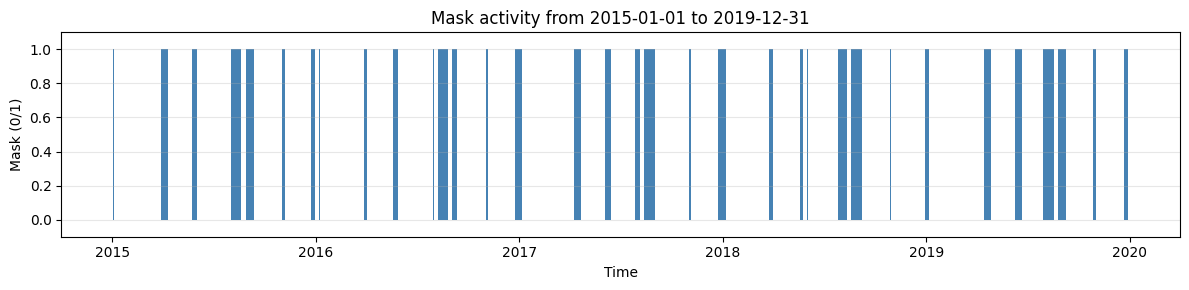

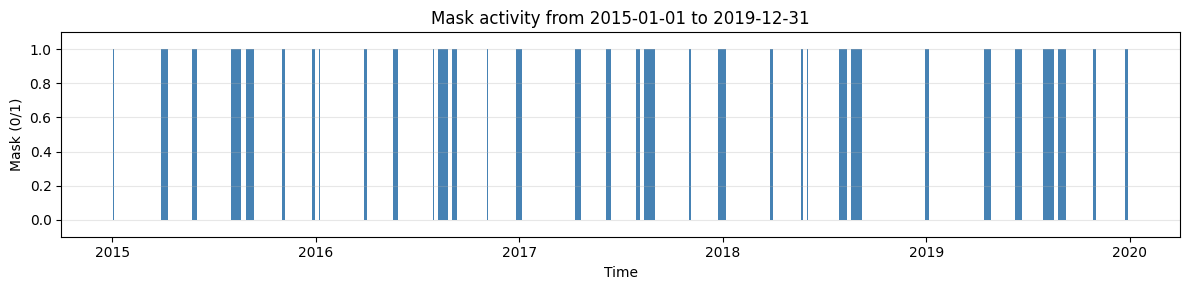

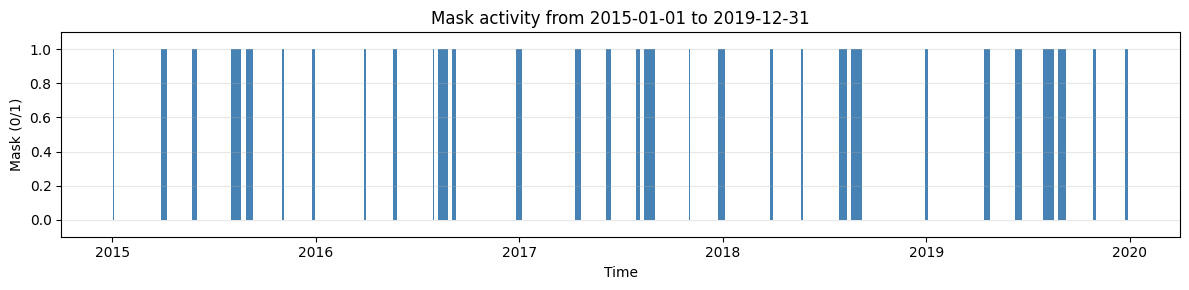

In [25]:
plot_mask_over_time(
    df=BW_load_hol_df_hol_inout,
    mask=BW_school_freeness_1_2_mask,
    start_date="2015-01-01",
    end_date="2019-12-31",
    ts_col="utc_timestamp"
)
plot_mask_over_time(
    df=BW_load_hol_df_hol_inout,
    mask=BW_school_freeness_2_2_mask,
    start_date="2015-01-01",
    end_date="2019-12-31",
    ts_col="utc_timestamp"
)
plot_mask_over_time(
    df=BW_load_hol_df_hol_inout,
    mask=BW_school_freeness_2_3_mask,
    start_date="2015-01-01",
    end_date="2019-12-31",
    ts_col="utc_timestamp"
)
